# GAN Main.py

copy it to another .py file and then run it. this will save around 30% time.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

# Training Hyperparameters
device=torch.device('cuda')
num_epochs = 100
batch_size = 64



# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_shape),
            nn.Tanh()  # Tanh activation for images in the range [-1, 1]
        )
        

    def forward(self, z): # z means latent variables
        img = self.fc(z)
        return img

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(img_shape, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, img):
        validity = self.fc(img)
        return validity

# Hyperparameters
latent_dim = 100
img_shape = 28 * 28  # Assuming MNIST-like images

# Create the generator and discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Loss and optimizers

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)



# Load a dataset (e.g., MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for epoch in tqdm(range(num_epochs)):
    for i, (real_imgs, real_labels) in enumerate(dataloader):
        real_imgs=real_imgs.to(device)
        real_labels=real_labels.to(device)
        
        # Adversarial ground truths
        batch_size = real_imgs.size(0)
        valid = torch.ones((batch_size, 1),device=device)
        fake = torch.zeros((batch_size, 1),device=device)

        # Generate a batch of random noise
        z = torch.randn((batch_size, latent_dim),device=device)

        # Generate fake images
        fake_imgs = generator(z)

        # Train the discriminator：尽可能分辨真伪
        optimizer_D.zero_grad()
        
        # BCELoss(p,y) = -[y * log(p) + (1 - y) * log(1 - p)], 
        # when y=1, BCELoss=-log(p),
        # when y=0, BCELoss=-log(1-p).
        # BCELoss(D(x),1)+BCELoss(D(G(z)),0)=-(log(D(x))+log(1-D(G(z))))
        # Here, our objective function is log D ( x^(i)) + log ( 1−D ( G ( z^(i) )))
        real_loss = F.binary_cross_entropy(discriminator(real_imgs.view(real_imgs.size(0), -1)), valid)
        fake_loss = F.binary_cross_entropy(discriminator(fake_imgs.detach().view(fake_imgs.size(0), -1)), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train the generator ：尽可能骗过判别器
        optimizer_G.zero_grad()
        # 此时y=1，BCELoss=-log(D(G(z)),此时，D越把G(z)当作真的，BCELoss的绝对值越小。
        # 值得注意的是，文中的优化公式是min log(1-D(G(z)))。其实我们不需要管优化公式是什么，
        # 是先有为了让D(G(z))越等于1越好，才构建了min(log(1-D(G(z))))这个优化公式。
        # 不用min(log(1-D(G(z))))，用这里的-log(D(G(z)))也是可以的。
        # 只要目的是让D(G(z))越等于1 就行了。
        
        
        # 总结一下：在设计loss公式的时候，我们先明确让哪个参数趋近于什么数值，然后再构建loss公式。
        # 像BCE这个公式，原本意思是交叉熵，这里用得到交叉熵吗？与交叉熵有半毛钱关系？没有！仅仅为了让D(G(z))越等于1越好，才用了BCE这个公式。
        g_loss = F.binary_cross_entropy(discriminator(fake_imgs.view(fake_imgs.size(0), -1)), valid) # 
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if i%100==0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


# Save the generator model
torch.save(generator, 'generator.pth')


 24%|██▍       | 24/100 [02:31<07:58,  6.30s/it]


KeyboardInterrupt: 

# Test

tensor([ 7.5538e-01, -1.1060e+00,  1.4154e-02,  1.8166e+00,  9.7260e-01,
         7.3911e-01,  1.1362e+00, -2.1919e-01, -2.6166e-01,  1.7537e-01,
        -3.7831e-01, -1.0045e+00,  1.7210e-01, -9.9889e-02, -1.5161e-01,
         2.0186e+00, -1.6234e+00, -2.2367e-01,  1.5270e-01, -2.4648e-01,
         9.2172e-02, -2.8611e+00,  1.7277e+00,  8.4588e-01, -1.1676e+00,
        -1.4734e+00,  1.5840e+00,  6.1559e-01, -5.2773e-01, -1.1811e+00,
        -8.3797e-01, -7.5302e-01,  6.8661e-01,  5.6405e-01, -1.6694e+00,
         1.9370e-01,  8.9552e-01,  1.6324e+00, -1.5163e-01,  4.1879e-01,
         3.9136e-01,  1.1247e-01,  8.2772e-01,  1.2552e+00, -4.5283e-01,
         6.2761e-01, -4.9821e-01, -8.7863e-02, -1.0160e+00,  4.4731e-01,
         1.3905e-01,  5.1434e-01,  1.5279e+00, -3.0038e-01, -4.5794e-01,
         3.0183e-01,  1.2163e+00, -2.9859e-01,  1.8579e-01,  8.0573e-01,
        -5.4074e-02, -1.1444e+00, -5.0744e-01, -1.1666e-01,  8.1321e-01,
         2.0673e+00,  6.2619e-01, -2.9625e-01, -5.4

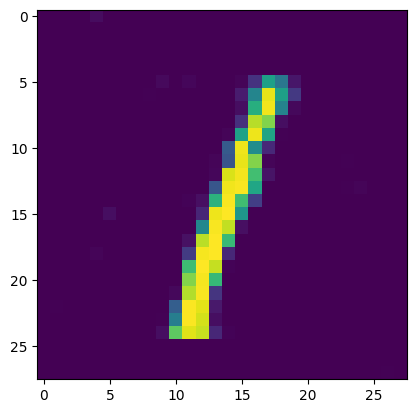

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_shape),
            nn.Tanh()  # Tanh activation for images in the range [-1, 1]
        )
        

    def forward(self, z): # z means latent variables
        img = self.fc(z)
        return img


latent_dim=100
device=torch.device('cpu')
G=torch.load('generator.pth').to(device)
z=torch.randn(latent_dim).to(device)

print(z)
image=G(z).detach().numpy().reshape((28,28))


plt.imshow(image)
plt.show()

### Comment 
(Wrote in my thinking language (first language), use [chatgpt](https://chat.openai.com) to translate if you want to know what they mean.

在GAN这篇文章里面，作者提出了Algorithm 1 Minibatch stochastic gradient descent training of generative adversarial nets.原文如下  
>```
>for number of training iterations do
>  for k steps do  
>  ```
>  - Sample minibatch of m noise samples $\{ z^{(1)}, . . . , z^{(m)}\}$ from noise prior $p_g(z)$.  
>  - Sample minibatch of m examples $\{x^{(1)}, . . . , x^{(m)}\}$ from data generating distribution $p_{data}(x)$.  
>  - Update the discriminator by ascending its stochastic gradient(SGA): 
>  $$ 
>  \nabla_{θ_d}\frac{1}m \sum_{i=1}^{m} [ log D ( x^{(i)}) + log ( 1−D ( G ( z^{(i)} )))] 
>  $$  
>```
>  end for
>```
> 
>  - Sample minibatch of m noise samples $\{z^{(1)}, . . . , z^{(m)}\}$ from noise prior $p_g(z)$. 
>  - Update the generator by descending its stochastic gradient(SGD): 
>  $$
>  \nabla_{\theta_g} \frac{1}m \sum_{i=1}^m log ( 1−D ( G ( z^{(i)})))
>  $$
>  ```
>  end for
>  ```
>  The gradient-based updates can use any standard gradient-based learning rule. We used momentum in our experiments.   





JIAN： The author applied a SDA to discriminator while a SDG to generator!  
SGA:  
第一项,D(x),x是从dataset中拿出来的，我们需要D(x)越=1越好，此时项越接近0
第二项，G（z）为从噪音中生成的图片，我们需要D(G(z))越=0越好，此时项越接近0
这么看来,这也应该是求SGD阿，为什么是SGA？
作者的说法是错误的，应该还是descending，只是BCELoss是负数，objective function




在main.py中，首先定义两个MLP，一个是generator，一个是discriminator。对应GAN这篇文章的G & D。
训练时：
数据准备，从dataloader中拿一个batch的数据来，分别为real_images和real_labels  
random出 64个 z出来，作为latent variable。
然后将这64个z放入Generator中去，获得fake_images。
然后训练用一半real,一半fake来训练discriminator
然后用fake来训练generator
over



$$\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x∼p_{data}}(x)[log D(x)] + E_{z∼p_z}(z) [log(1 − D(G(z)))]$$




Your worry is right. Here is a terminology confusion.

Consider this objective function:
$$\log D ( x^{(i)}) + \log ( 1−D ( G ( z^{(i)} )))$$

The first term requires $D$ to correctly recognise real data. The closer $D(x)$ is to 1 (True), the closer the term $\log D ( x^{(i)})$ is to 0. And this term is always negative or 0. Similarly, for the second term $\log ( 1−D ( G ( z^{(i)} )))$, situation is the same. They all requires the objective function as closer to zero as possible, which in numeral is ascending the objective function to zero.

The description here is misleading, as we usually refer 'stochastic gradient descending (SGD)' as a method for weight updating but not to describe the actual value of objective functions.

The sentences 
>'Update the discriminator by **ascending** its stochastic gradient'  
>'Update the generator by **descending** its stochastic gradient' 

should be replaced with  

>'Update the discriminator with an optimiser for **ascending the objective 
function's value**'  
>'Update the generator with an optimiser for **descending the objective 
function's value**'  

if we must use 'ascending' and 'descending' here.


# The end of original GAN